In [16]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import deeplake

In [17]:
# Load the dataset (LSP)
# The dataset is in the form of a dictionary with three keys: 'images', 'keypoints', 'images_visualized'
# 'images' is the original image
# 'keypoints' is the ground truth keypoints
# 'images_visualized' is the original image with the ground truth keypoints visualized
# However, the image and visualized image are different in size and the keypoints are not aligned with the original image but with the visualized image
# The dataset is split into train and test
ds_train = deeplake.load("hub://activeloop/lsp-train")
ds_test = deeplake.load("hub://activeloop/lsp-test")

# The dataset can be converted to a tensorflow dataset
dataloader_train = ds_train.tensorflow()
dataloader_test = ds_test.tensorflow()

|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-train



\

hub://activeloop/lsp-train loaded successfully.



/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-test



/

hub://activeloop/lsp-test loaded successfully.



In [18]:
# Function to normalize the keypoints
# The bounding box is in the form of [x,y,w,h] where x and y are the coordinates of the center of the bounding box and w and h are the width and height of the bounding box
# This function is the same as the one in the paper
def normalize_keypoints(keypoints,bounding_box):
    keypoints[:,0] = (keypoints[:,0] - bounding_box[0])/bounding_box[2]
    keypoints[:,1] = (keypoints[:,1] - bounding_box[1])/bounding_box[3]
    return keypoints

In [19]:
# Function to unnormalize the keypoints
# This function is the same as the one in the paper
def unnormalize_keypoints(keypoints,bounding_box):
    keypoints[:,0] = (keypoints[:,0]*bounding_box[2]) + bounding_box[0]
    keypoints[:,1] = (keypoints[:,1]*bounding_box[3]) + bounding_box[1]
    keypoints[:,0] = np.clip(keypoints[:,0],0,bounding_box[2])
    keypoints[:,1] = np.clip(keypoints[:,1],0,bounding_box[3])
    return keypoints.astype(np.int32)

In [20]:
# Function to visualize the keypoints
# image_visualized is needed to get the size of the image on which the keypoints are aligned
# This draws the keypoints and the lines connecting the keypoints
def visualize_keypoints(image,keypoints,image_visualized):
    height,width = image_visualized.shape[:2]
    try:
        image = cv2.resize(image.numpy(),(width,height))
    except:
        image = cv2.resize(image,(width,height))
    fig , ax = plt.subplots(1,figsize=(10,10))
    ax.imshow(image)
    ax.scatter(keypoints[:,0],keypoints[:,1])
    for i in range(keypoints.shape[0]):
        ax.annotate(str(i), (keypoints[i,0],keypoints[i,1]),fontsize=10)
    for i in range(0,5):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    for i in range(6,11):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    for i in range(12,13):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    plt.show()

In [21]:
# Visualize on a sample image
batch_iter = iter(dataloader_train)
batch = next(batch_iter)

2023-05-05 18:58:07.291672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


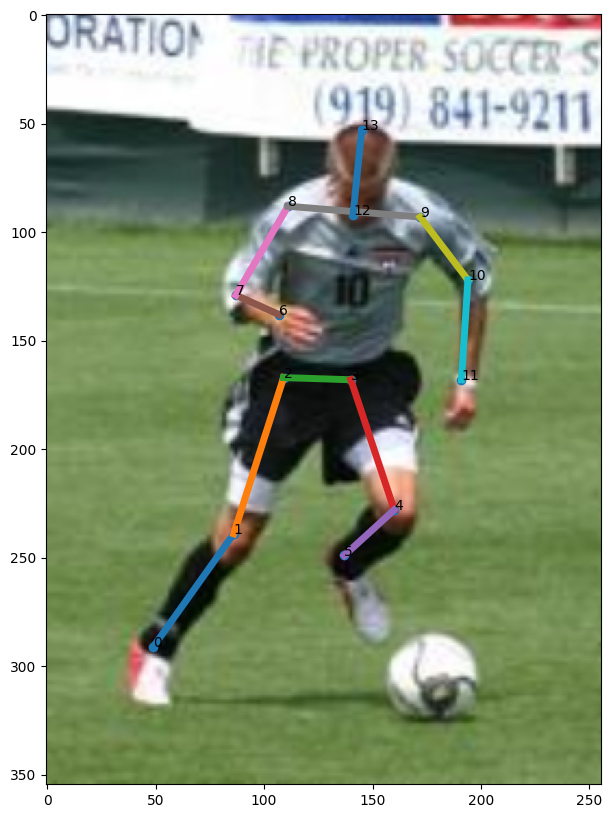

In [22]:
# Get the image and the keypoints
batch = next(batch_iter)
image = batch["images"]
keypoints = batch["keypoints"]
image_visualized = batch["images_visualized"]

# Visualize the keypoints
visualize_keypoints(image,keypoints,image_visualized)

In [23]:
# Get all the images and keypoints from the dataset and store them in a numpy array for training
# The keypoints are normalized and stored in the keypoints_array
# The images are resized to 220x220 and stored in the images array (also normalized to 0-1)
images = []
keypoints_array = []

# Iterate over the training dataset and store the images and keypoints
for batch in dataloader_train:
    image = batch["images"]
    keypoints = batch["keypoints"].numpy().astype(np.float32)
    keypoints = keypoints[:,0:2]
    image_visualized = batch["images_visualized"].numpy()
    height,width = image_visualized.shape[:2]
    keypoints = normalize_keypoints(keypoints,(width/2,height/2,width,height))
    image = cv2.resize(image.numpy(),(220,220)).astype(np.float32)/255.0
    images.append(image)
    keypoints_array.append(keypoints)

# Since the dataset is small, we can also use the test dataset for training
# Iterate over the test dataset and store the images and keypoints
for batch in dataloader_test:
    image = batch["images"]
    keypoints = batch["keypoints"].numpy().astype(np.float32)
    keypoints = keypoints[:,0:2]
    image_visualized = batch["images_visualized"].numpy()
    height,width = image_visualized.shape[:2]
    keypoints = normalize_keypoints(keypoints,(width/2,height/2,width,height))
    image = cv2.resize(image.numpy(),(220,220)).astype(np.float32)/255.0
    images.append(image)
    keypoints_array.append(keypoints)

# Convert the images and keypoints_array to numpy arrays
images = np.array(images)
keypoints_array = np.array(keypoints_array,dtype=np.float32)

2023-05-05 18:58:14.584450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [24]:
# Create a model
# The model is the same as the one in the paper
# This is also called the AlexNet model
# Use batch normalization for wherever LRN is used in the paper
# Output is 14*2 (14 keypoints with x and y coordinates)
def get_model():
    model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(96,(11,11),strides=(4,4),activation="relu",input_shape=(220,220,3)),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2),strides=(2,2)),
                                        tf.keras.layers.Conv2D(256,(5,5),activation="relu",padding="same"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2),strides=(2,2)),
                                        tf.keras.layers.Conv2D(384,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Conv2D(384,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Conv2D(256,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2)),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(4096,activation="relu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(4096,activation="relu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(14*2,activation="linear")])
    return model


In [25]:
# Get the model
model = get_model()

In [26]:
# A custom loss function is used
# The loss function is the same as the one in the paper (L2 loss)
# The loss function is the sum of the squared difference between the predicted and ground truth keypoints
# Reshape the predicted keypoints(batch_size,28) to (batch_size,14,2) before calculating the loss
def loss_fn(y_true,y_pred):
    y_pred = tf.reshape(y_pred,(-1,14,2))
    return tf.reduce_sum(tf.square(y_true-y_pred))

In [27]:
# Check for a sample image
sample = images[0]
sample = cv2.resize(sample,(220,220)).astype(np.float32)/255.0
sample = np.expand_dims(sample,axis=0)
sample = tf.convert_to_tensor(sample,dtype=tf.float32)
pred = model(sample)

In [28]:
# Calculate the loss
loss_fn(keypoints_array[0],pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1279013>

In [29]:
# Compile the model with Adam optimizer and the custom loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=loss_fn)

In [30]:
# Train the model
# model.fit(images,keypoints_array,epochs=10,batch_size=2,validation_split=0.1,shuffle=True,verbose=1)

In [31]:
# Save the model
# model.save("deeppose.h5")

In [49]:
# Load the model
model = tf.keras.models.load_model("deeppose.h5",custom_objects={"loss_fn":loss_fn})

In [50]:
# Function to get the predictions from the model for a given image
def get_preds(model,image):
    image= cv2.resize(image,(220,220))
    image = np.expand_dims(image,axis=0)
    image = tf.convert_to_tensor(image,dtype=tf.float32)
    pred = model(image)
    pred = tf.reshape(pred,(14,2))
    return pred

In [51]:
# Make predictions on a sample image
test_iter = iter(dataloader_test)

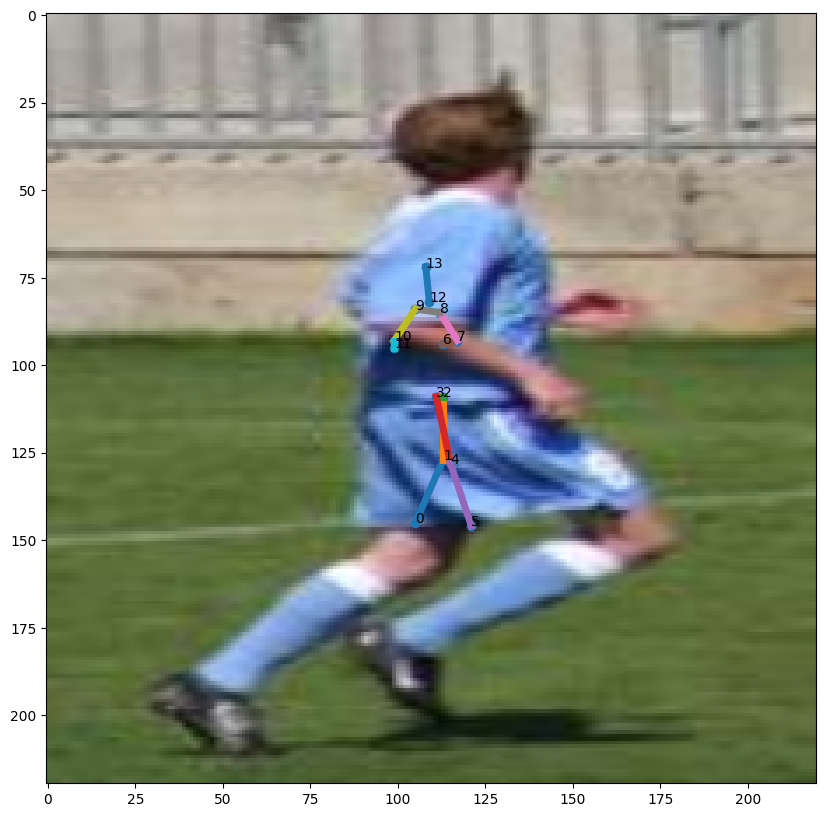

In [52]:
# Visualize the predictions
# We will see that the model performs resonably well on our dataset
img = next(test_iter)["images"].numpy()
img = cv2.resize(img,(220,220))
image = cv2.resize(img,(220,220)).astype(np.float32)/255.0
pred = get_preds(model,image).numpy()
keypoints = unnormalize_keypoints(pred,(110,110,220,220))
visualize_keypoints(img,keypoints,img)

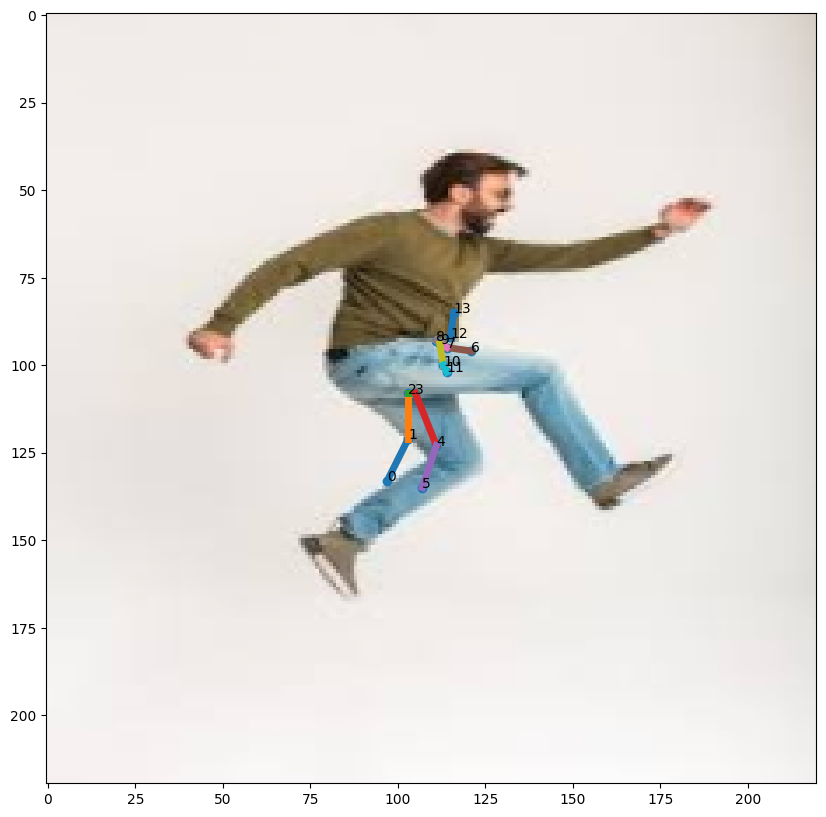

In [60]:
# Test on a random image
# We can see that the model is not able to generalize well
img = cv2.imread("test.jfif")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(220,220))
image = cv2.resize(img,(220,220)).astype(np.float32)/255.0
pred = get_preds(model,image).numpy()
keypoints = unnormalize_keypoints(pred,(110,110,220,220))
visualize_keypoints(img,keypoints,img)